In [182]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math
from sklearn.metrics import average_precision_score
from sklearn.metrics import roc_auc_score

In [183]:
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

In [184]:
def prepare_data(file_name='./train.csv'):
    train_df = pd.read_csv(file_name)
    train_df.drop(train_df.columns[0],axis=1,inplace=True)
    train_npa = train_df.to_numpy()
    
    train_data = []
    max_item_id = 0
    max_user_id = train_npa.shape[0]

    for i, docs in enumerate(train_npa):
        tmp_arr = np.array(list(map(int, list(docs)[0].split())))
        tmp_max = np.max(tmp_arr)
        if tmp_max > max_item_id:
            max_item_id = tmp_max
        train_data.append(tmp_arr)

    train_data = np.array(train_data, dtype=object)

    return train_data, max_item_id, max_user_id

In [185]:
def create_rating_matrix(train_data, max_item_id, max_user_id):
    R = np.zeros((max_item_id, max_user_id))
    
    for i in range(max_item_id):
        for j in range(max_user_id):
            if i in train_data[j]:
                # user j interacted with item i
                R[i][j] = 1
    
    return R.T

In [186]:
def bce_loss(data, i, j):
    hor_sum = np.sum(data, axis=1)
    vert_sum = np.sum(data, axis=0)
    
    return -(data[i, j]*np.ln(hor_sum[i]) + (1-data[i, j])*np.ln(1-vert_sum[j]))

In [187]:
def count_occurrences(row):
    return len([x for x in row if x == 1])

In [188]:
def gradient_descent(R, max_iter=100, learn_rate=0.001, lamb=0.001, dim=16):
    Q = np.random.uniform(0, 1, size=(R.shape[0], dim))
    P = np.random.uniform(0, 1, size=(R.shape[1], dim))
    
    for iters in range(max_iter):
        r = np.random.randint(0, Q.shape[0])
        for i in range(P.shape[0]):
            y = R[r, i]
            p = np.dot(Q[r], P[i])
            eps = (-y/p)+((1-y)/(1-p))
            eps = np.sign(p)*eps

            Q[r] = Q[r] + learn_rate*(-eps*P[i]-lamb*Q[r])
            P[i] = P[i] + learn_rate*(-eps*Q[r]-lamb*P[i])
            
            
            
        r = np.random.randint(0, P.shape[0])
        for i in range(Q.shape[0]):
            y = R[i, r]
            p = np.dot(Q[i], P[r])
            eps = (-y/p)+((1-y)/(1-p))
            
            eps = np.sign(p)*eps
    
            Q[i] = Q[i] + learn_rate*(-eps*P[r]-lamb*Q[i])
            P[r] = P[r] + learn_rate*(-eps*Q[i]-lamb*P[r])
                
    return P, Q

In [189]:
def get_most_relevant(mat, n=50):
    res = []
    
    for i in range(mat.shape[0]):
        d = dict(enumerate(mat[i]))
        sl = sorted(d.items(), key=lambda item: item[1], reverse=True)
        res.append(sl[:n])

    return res

In [190]:
def output_result_csv(M, output_filename):
    relevant_items = get_most_relevant(M)
    rel_items = [[x[0] for x in l] for l in relevant_items]
    rel_items = dict(enumerate(rel_items))

    for k, v in rel_items.items():
        rel_items[k] = ' '.join(str(x) for x in v)
        
    res = pd.DataFrame([{'ItemId': v} for v in rel_items.values()], index=rel_items.keys())
    res.index.name = 'UserId'
    
    res.to_csv(output_filename)  
        

In [191]:
def bpr_sgd(R, max_iter=100, learn_rate=0.001, lamb=0.001):
    batch_size = 1000
    n_factors = 64
    b_iter = int(R.shape[0]/batch_size)

    rstate = np.random.RandomState(2727)
    Q = rstate.normal(size = (R.shape[0], n_factors))
    P = rstate.normal(size = (R.shape[1], n_factors))
    
    for it in range(max_iter):
        for b_it in range(b_iter):
            i = np.zeros(batch_size, dtype = np.int)
            j = np.zeros(batch_size, dtype = np.int)
            u = np.random.choice(R.shape[0], size = batch_size, replace = False)
            
            for idx, user in enumerate(u):
                pos_items = np.where(np.array(R[user]) == 1)[0]
                pos_item = np.random.choice(pos_items)
                
                neg_items = np.where(np.array(R[user]) == 0)[0]
                neg_item = np.random.choice(neg_items)

                i[idx] = pos_item
                j[idx] = neg_item
            
            xuij = np.sum(Q[u] * (P[i] - P[j]), axis = 1)

            sig = np.exp(-xuij) / (1.0 + np.exp(-xuij))
            sig_t = np.tile(sig, (n_factors, 1)).T

            du = sig_t * (P[j] - P[i]) + lamb * Q[u]
            di = sig_t * -Q[u] + lamb * P[i]
            dj = sig_t * Q[u] + lamb * P[j]
            
            Q[u] -= learn_rate * du
            P[i] -= learn_rate * di
            P[j] -= learn_rate * dj
    
    return P, Q

In [192]:
train_data, max_item_id, max_user_id = prepare_data()

In [193]:
# R = create_rating_matrix(train_data, max_item_id, max_user_id)

In [194]:
test_size = 0.2
rstate = np.random.RandomState(2727)
train = R.copy()
test = np.zeros(R.shape)

for u in range(R.shape[0]):
    divs = math.ceil(test_size * R.shape[1])
    tidx = rstate.choice(R.shape[1], size = divs, replace = False)
    test[u, tidx] = R[u, tidx]
    train[u, tidx] = 0

In [195]:
# M: number of users, N: number of items
M, N = R.shape[0], R.shape[1]

In [196]:
BCE_P, BCE_Q = gradient_descent(train)

In [197]:
BCE_M = np.matmul(BCE_Q, BCE_P.T)

In [198]:
BPR_P, BPR_Q = bpr_sgd(train)

In [199]:
BPR_M = np.matmul(BPR_Q, BPR_P.T)

In [200]:
output_result_csv(BCE_M, 'BCE_output.csv')

In [201]:
output_result_csv(BPR_M, 'BPR_output.csv')

In [202]:
def submission_to_npa(filename):
    df = pd.read_csv(filename)
    npa = df.to_numpy()
    sa = []
    for idx, r in enumerate(npa):
        sa.append(np.array(npa[idx][1].split(' '), dtype=np.int))
    sa = np.array(sa, dtype=object)
    
    return sa

In [203]:
def MAP(R, sa, user):
    true_labels = R
    output_labels = np.zeros(true_labels.shape)

    for i in range(sa.shape[0]):
        for j in range(sa.shape[1]):
            output_labels[i][sa[i][j]] = 1
    
    return average_precision_score(true_labels[user], output_labels[user])

In [204]:
def aMAP(R, sa):
    
    true_labels = R
    output_labels = np.zeros(true_labels.shape)

    for i in range(sa.shape[0]):
        for j in range(sa.shape[1]):
            output_labels[i][sa[i][j]] = 1
    
    print(output_labels.shape)
    
    tmp = []
    for u in range(R.shape[0]):
        tmp.append(average_precision_score(true_labels[u], output_labels[u]))
    
    return np.mean(np.array(tmp))

In [205]:
BCE_sa = submission_to_npa('BCE_output.csv')
BPR_sa = submission_to_npa('BPR_output.csv')

In [206]:
BCE_aMAP = aMAP(R, BCE_sa)
BPR_aMAP = aMAP(R, BPR_sa)

(4454, 3259)
(4454, 3259)


In [207]:
BCE_aMAP

0.021700841339854404

In [208]:
BPR_aMAP

0.02158983054644428

In [209]:
# 16: 0.021580195521250314
# 32: 0.021587614528965734
# 64: 0.021588001175069555
# 128: 0.021570575442673816

<function matplotlib.pyplot.xticks(ticks=None, labels=None, **kwargs)>

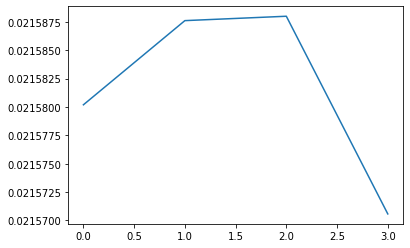

In [210]:
plt.plot(range(4), [0.021580195521250314, 0.021587614528965734, 0.021588001175069555, 0.021570575442673816])
plt.xticks